<a href="https://colab.research.google.com/github/JericCantos/RetailDemandAnalysis/blob/main/notebooks/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Load Data

In [1]:
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt


## Load CSVs

In [2]:
# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# Dictionary of file IDs for clarity
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Load each CSV using the helper functions
df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
# df_train          = load_csv_from_url(make_drive_url(file_ids["train"])) we dont read it as the file is too big and wont work this way
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


In [ ]:
df_holiday_events[df_holiday_events['transferred']==True].head()

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True


## Loading df_train

filter only to stores in "Guayas"

In [ ]:
!pip install -U gdown

In [ ]:
import gdown

# Use our existing function to build the download URL
train_url = make_drive_url(file_ids["train"])

# Download the file using gdown
gdown.download(train_url, "train.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=94fd072a-1e42-4908-b942-e7e90f09563a
To: /content/train.csv
100%|██████████| 5.00G/5.00G [01:38<00:00, 50.9MB/s]


'train.csv'

In [ ]:
# select only stores in 'Guayas' state
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()


# read the imported. data in chunks
chunk_size = 10**6  # 1 million rows at a time
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk  # Free up memory

# combine all chunks into one dataframe
df_train = pd.concat(filtered_chunks, ignore_index=True)

# down-sample to 2 million rows
df_train = df_train.sample(n=2_000_000).reset_index(drop=True)

/tmp/ipython-input-946473318.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("train.csv", chunksize=chunk_size):


In [ ]:
# free up memory
del filtered_chunks

### Filter by Product Family
- keep only the three biggest product families (measured by how many unique items each family contains)

In [ ]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [ ]:
df_items['family'].value_counts().head(3)
# top three families are: GROCERY I,  BEVERAGES, and CLEANING

,count
family,
GROCERY I,1334
BEVERAGES,613
CLEANING,446


In [ ]:
# join df_train with df_items then filter only top 3

top_3_families = ['GROCERY I',  'BEVERAGES', 'CLEANING']

df_train_family = pd.merge(
    df_train,
    df_items,
    on = 'item_nbr',
    how = 'inner'

    )

df_train_family.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,family,class,perishable
0,2013-02-17,1895433,24,96995,1.0,False,False,GROCERY I,1093,0
1,2013-02-18,0,24,96995,0.0,False,False,GROCERY I,1093,0
2,2013-02-19,0,24,96995,0.0,False,False,GROCERY I,1093,0
3,2013-02-20,0,24,96995,0.0,False,False,GROCERY I,1093,0
4,2013-02-21,0,24,96995,0.0,False,False,GROCERY I,1093,0


In [ ]:
print ('original dataset length:', len(df_train),
       '\nwith families length:', len(df_train_family) )
df_train = df_train_family[df_train_family['family'].isin(top_3_families)]

print ('filtered top 3 length:', len(df_train))

original dataset length: 35723327 
with families length: 35723327
filtered top 3 length: 22282463


In [ ]:
df_train['family'].unique()

array(['GROCERY I', 'CLEANING', 'BEVERAGES'], dtype=object)

### Save Pickle

In [ ]:
# 1. Mount Drive (one-time click to authorize)
from google.colab import drive
drive.mount('/content/drive')

# 2. Pick a folder inside Drive (create it if it doesn’t exist)
save_path = "/content/drive/MyDrive/Masterschool_Time_Series/df_train_clean.pkl"


# 3. SAVE the cleaned DataFrame
df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")



Mounted at /content/drive
Saved to: /content/drive/MyDrive/Masterschool_Time_Series/df_train_clean.pkl


### Load Pickle



In [3]:
# -----------------------------------------------
# Uncomment and Run this to reload dataframe
# -----------------------------------------------


from google.colab import drive
drive.mount('/content/drive')              # re-mount
load_path = "/content/drive/MyDrive/Masterschool_Time_Series/df_train_clean.pkl" #example of path, use the same as above
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame reloaded, ready to go!


# Data Cleaning

## Check for Missing Data

### df_train
Almost 240k rows with null onpromotioon exist. No other null values exist.

given that this is roughly 18% of the data, dropping the rows will not be a good option.
Question would be whether to drop the column, or impute it.

Based on the remainder of the dataset, more than 94% of the rows have onpromotion = False, so it seems better to replace nulls with False.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1284286 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           1284286 non-null  int64  
 1   date         1284286 non-null  object 
 2   store_nbr    1284286 non-null  int64  
 3   item_nbr     1284286 non-null  int64  
 4   unit_sales   1284286 non-null  float64
 5   onpromotion  1044632 non-null  object 
 6   family       1284286 non-null  object 
 7   class        1284286 non-null  int64  
 8   perishable   1284286 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 98.0+ MB


In [5]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,239654
family,0
class,0
perishable,0


In [6]:
df_train['onpromotion'].value_counts(normalize=True)

,proportion
onpromotion,
False,0.94351
True,0.05649


In [7]:
df_train.loc[:,'onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

df_train.isnull().sum()

/tmp/ipython-input-3922442648.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train.loc[:,'onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
family,0
class,0
perishable,0


### df_oil
- 43 nulls for the dcoilwtico column.
- dropping this does not seem to be a good idea since this seems to be a time series too, and each date is unique.
- for now, I will try linear interpolation to fill the nulls.
- since the very first row has a null value, I will just backward fill it.

In [8]:
df_oil.isnull().sum()

,0
date,0
dcoilwtico,43


In [9]:
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')
df_oil.isnull().sum()

,0
date,0
dcoilwtico,1


In [10]:
#backward fill the first row
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].bfill()
df_oil.isnull().sum()

,0
date,0
dcoilwtico,0


In [11]:
df_oil.iloc[:2, :]

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14


### df_items, df_holiday_events, df_stores, df_transactions
No nulls

In [12]:
df_items.isnull().sum()

,0
item_nbr,0
family,0
class,0
perishable,0


In [13]:
df_holiday_events.isnull().sum()

,0
date,0
type,0
locale,0
locale_name,0
description,0
transferred,0


In [14]:
df_stores.isnull().sum()

,0
store_nbr,0
city,0
state,0
type,0
cluster,0


In [15]:
df_transactions.isnull().sum()

,0
date,0
store_nbr,0
transactions,0


## Fill Missing Dates with Zero Sales

In [16]:
# Turn the date column into real dates

df_train['date'] = pd.to_datetime(df_train['date'])

In [17]:
# define a function to create a full daily calendar
# for every store-item pair
# expect df_train.groupby(['store_nbr', 'item_nbr'])

def fill_calendar(group):
  #
  # group contains all rows for ONE (store_nbr, item_nbr) pair
  #
  g = group.set_index("date").sort_index()   # use date/calendar as the index

  g = g.asfreq("D", fill_value=0)
  # make it daily; add 0 to all columns where the date is missing

	# put the identifiers back (asfreq drops them)
  g.loc[:,"store_nbr"] = group["store_nbr"].iloc[0]
  g.loc[:,"item_nbr"] = group["item_nbr"].iloc[0]

  g = g.infer_objects()  # force consistent datatype to suppress warning
  return g.reset_index() # date back to a normal column

In [18]:
# Apply the function to every store-item pair
df_train = (
    df_train
    .groupby(["store_nbr", "item_nbr"], group_keys=False)  # keeps memory low
    .apply(fill_calendar)
)

df_train.head(25)

/tmp/ipython-input-2293031412.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
0,2013-01-17,622071,24,96995,2.0,False,GROCERY I,1093,0
1,2013-01-18,0,24,96995,0.0,0,0,0,0
2,2013-01-19,0,24,96995,0.0,0,0,0,0
3,2013-01-20,0,24,96995,0.0,0,0,0,0
4,2013-01-21,0,24,96995,0.0,0,0,0,0
5,2013-01-22,0,24,96995,0.0,0,0,0,0
6,2013-01-23,0,24,96995,0.0,0,0,0,0
7,2013-01-24,0,24,96995,0.0,0,0,0,0
8,2013-01-25,0,24,96995,0.0,0,0,0,0
9,2013-01-26,0,24,96995,0.0,0,0,0,0


## Check for Outliers

### Treat product returns as no sale

In [19]:
#replace all negative unit_sales with 0
df_train.loc[:,'unit_sales'] = df_train['unit_sales'].apply(
                        lambda x: 0 if x<0 else x)

df_train.describe()

,date,id,store_nbr,item_nbr,unit_sales,class,perishable
count,22272053,2.227205e+07,2.227205e+07,2.227205e+07,2.227205e+07,2.227205e+07,22272053.0
mean,2015-08-25 05:51:15.758039296,3.545847e+06,3.219148e+01,9.113715e+05,3.931700e-01,8.532803e+01,0.0
min,2013-01-02 00:00:00,0.000000e+00,2.400000e+01,9.699500e+04,0.000000e+00,0.000000e+00,0.0
25%,2014-08-26 00:00:00,0.000000e+00,2.700000e+01,4.545960e+05,0.000000e+00,0.000000e+00,0.0
50%,2015-10-22 00:00:00,0.000000e+00,3.000000e+01,9.118710e+05,0.000000e+00,0.000000e+00,0.0
75%,2016-09-17 00:00:00,0.000000e+00,3.500000e+01,1.243815e+06,0.000000e+00,0.000000e+00,0.0
max,2017-08-15 00:00:00,1.254915e+08,5.100000e+01,2.127114e+06,1.043700e+04,3.090000e+03,0.0
std,NaN,1.678770e+07,7.601647e+00,5.214775e+05,4.828781e+00,3.948145e+02,0.0


### Identify outliers

only around 26% of our outliers are correlated with either promotions or holidays

In [20]:
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score for unit_sales
    # (avoiding division by zero for standard deviation),
    # and store it in a new column called z_score
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales
                                                             if std_sales != 0
                                                             else 1)
    return group

In [21]:
# Apply the Z-score calculation to each store-item group, then flatten the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr'])\
                            .apply(calculate_store_item_zscore,
                                   include_groups=True)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 211348


/tmp/ipython-input-3151766863.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_store_item_zscore,


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,z_score
62,2013-03-20,3198811,24,96995,4.0,False,GROCERY I,1093,0,8.015567
156,2013-06-22,7305077,24,96995,4.0,False,GROCERY I,1093,0,8.015567
300,2013-11-13,13913610,24,96995,4.0,False,GROCERY I,1093,0,8.015567
339,2013-12-22,15874598,24,96995,4.0,False,GROCERY I,1093,0,8.015567
391,2014-09-08,30510767,24,99197,2.0,False,GROCERY I,1067,0,9.544335


In [22]:
outliers['date'] = pd.to_datetime(outliers['date'])
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

# check whether outliers are correlated with holidays or promotions

#merge outliers with holidays
outliers_copy = pd.merge(outliers, df_holiday_events, how='left', on='date')

# check what the union of holidays and promotions are
on_promotion_or_holiday = len(outliers_copy[(outliers_copy['onpromotion']==True)
                              | (~outliers_copy['type'].isnull()) ])

not_promotion_nor_holiday = len(outliers_copy[(outliers_copy['onpromotion']==False)
                              & (outliers_copy['type'].isnull()) ])

total = len(outliers_copy)

print('Total Outliers:', total,
      '\n On Promotion or Holiday:', on_promotion_or_holiday,
      '\n Not on Promotion nor Holiday', not_promotion_nor_holiday,
      '\n % on Promotion nor Holiday', on_promotion_or_holiday*100/total)

Total Outliers: 216413 
 On Promotion or Holiday: 55667 
 Not on Promotion nor Holiday 160746 
 % on Promotion nor Holiday 25.722576739844648


/tmp/ipython-input-2885479365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['date'] = pd.to_datetime(outliers['date'])


In [23]:
outliers_copy['unit_sales'].describe()

,unit_sales
count,216413.000000
mean,13.475141
std,40.414327
min,1.000000
25%,4.000000
50%,7.000000
75%,14.000000
max,10437.000000


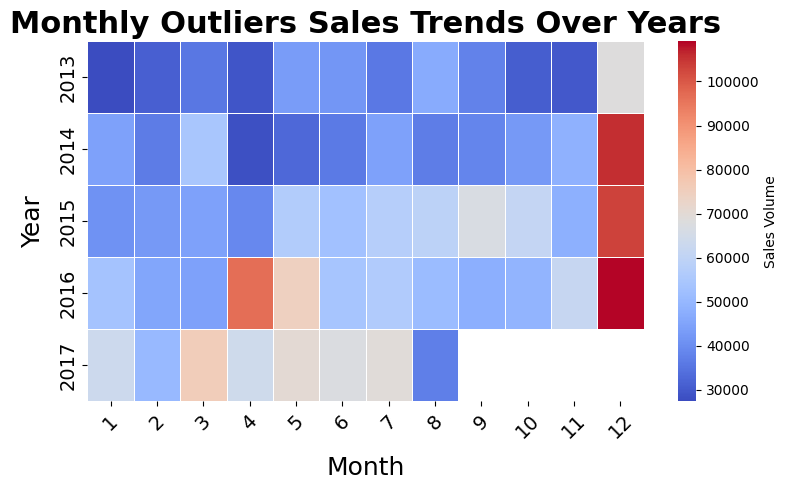

In [24]:
outliers_copy.loc[:, 'date'] = pd.to_datetime(outliers_copy['date'])
outliers_copy = outliers_copy.set_index('date').sort_index()
outliers_copy.reset_index(inplace=True, drop=False)


# Split the timestamp
outliers_copy['year'] = outliers_copy['date'].dt.year
outliers_copy['month'] = outliers_copy['date'].dt.month
outliers_copy['day'] = outliers_copy['date'].dt.day
outliers_copy['week'] = outliers_copy['date'].dt.isocalendar().week
outliers_copy['day_of_week'] = outliers_copy['date'].dt.day_of_week

# group by month and year, see if there's a trend to when the outliers occur
outliers_by_month = (
    outliers_copy.groupby(['year', 'month'])['unit_sales'].sum().unstack()
)

import seaborn as sns

plt.figure(figsize=(8,5))
sns.heatmap(
   outliers_by_month,
   cmap='coolwarm',
   linewidths=0.5,
   linecolor='white',
   cbar_kws={'label': 'Sales Volume'}
)

# Customizing title and axes labels
plt.title('Monthly Outliers Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Year', fontsize=18, labelpad=10)
# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
# Adjust layout for better spacing
plt.tight_layout()
# Display the heatmap
plt.show()

inconclusive by month, though slightly growth in december. Maybe by calendar week?

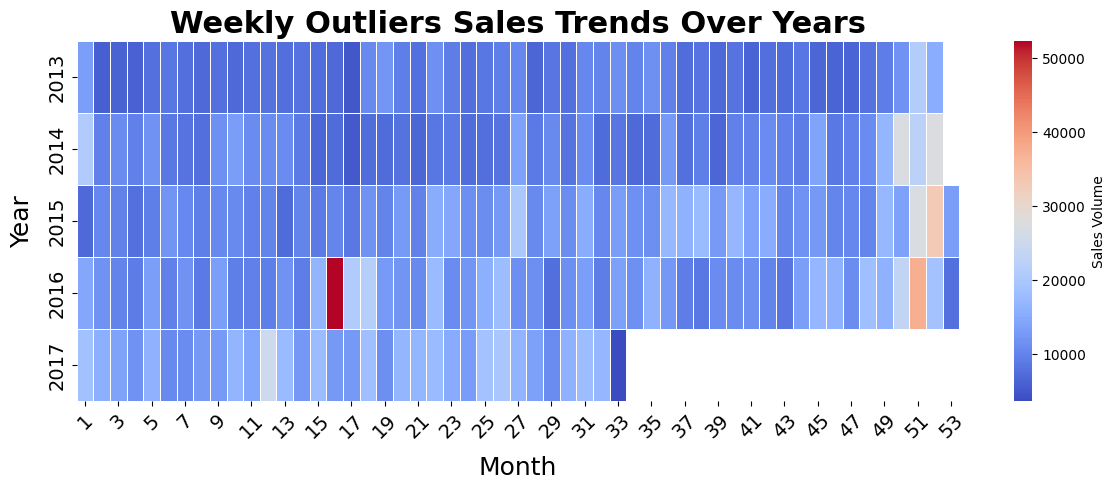

In [25]:
# group by week and year, see if there's a trend to when the outliers occur
outliers_by_week = (
    outliers_copy.groupby(['year', 'week'])['unit_sales'].sum().unstack()
)


plt.figure(figsize=(12,5))
sns.heatmap(
   outliers_by_week,
   cmap='coolwarm',
   linewidths=0.5,
   linecolor='white',
   cbar_kws={'label': 'Sales Volume'}
)

# Customizing title and axes labels
plt.title('Weekly Outliers Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Year', fontsize=18, labelpad=10)
# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
# Adjust layout for better spacing
plt.tight_layout()
# Display the heatmap
plt.show()

In [26]:
outliers_copy['day_of_week'].value_counts()

,count
day_of_week,
6,47939
5,41045
0,27807
1,26782
4,25506
2,25173
3,22161


Still can't find a trend. Random spot checks show that the outliers happen all over the calendar i.e. not necessarily only during summer or holiday periods. Most outliers seem to occur on Sundays and Saturdays, but the counts are not too far away from the rest of the days.


Right now I don't know whether to remove these outliers or re-scale. To preserve as much data as possible, I will just label the outliers in the training dataset.

In [27]:
df_train['is_outlier'] = df_train['id'].isin(outliers['id'])
df_train['is_outlier'].value_counts()

,count
is_outlier,
False,22060705
True,211348


# Feature Engineering

## Boolean Flags: onpromotion, is_outlier, perishable

In [28]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,is_outlier
0,2013-01-17,622071,24,96995,2.0,False,GROCERY I,1093,0,False
1,2013-01-18,0,24,96995,0.0,0,0,0,0,False
2,2013-01-19,0,24,96995,0.0,0,0,0,0,False
3,2013-01-20,0,24,96995,0.0,0,0,0,0,False
4,2013-01-21,0,24,96995,0.0,0,0,0,0,False


In [29]:
# onpromotion, outlier, perishable to type bool

df_train['onpromotion'] = df_train['onpromotion'].astype(bool)
df_train['is_outlier'] = df_train['is_outlier'].astype(bool)
df_train['perishable'] = df_train['perishable'].astype(bool)
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,is_outlier
0,2013-01-17,622071,24,96995,2.0,False,GROCERY I,1093,False,False
1,2013-01-18,0,24,96995,0.0,False,0,0,False,False
2,2013-01-19,0,24,96995,0.0,False,0,0,False,False
3,2013-01-20,0,24,96995,0.0,False,0,0,False,False
4,2013-01-21,0,24,96995,0.0,False,0,0,False,False


## Merge holiday info and clean NaN
- This makes the dataframe balloon and exceed RAM limits, causing the whole session to crash.
- Will for now replace with flag is_holiday instead. I would have wanted to include the other aspects e.g. holiday type, but I am blocked.

In [34]:
import gc

gc.collect()

12752

In [ ]:
# Crashes even with GPU/TPU Runtime

# merge with holiday calendar to see if sale happened during holiday
# and what type of holiday it is

# convert df_holiday_events date to datetime
# df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

# df_train = pd.merge(df_train, df_holiday_events, on='date', how='left')
# df_train.head()


NameError: name 'pd' is not defined

In [ ]:
# fill the nulls from holidays
# filling the nulls makes the dataframe balloon
# which causes the session to crash due to RAM limitations
# choosing to just do holiday type

# df_train['type'] = df_train['type'].fillna('Not a Holiday')
# df_train.isnull().sum()

In [ ]:
# uncomment later when memory is less of an issue
# df_train['locale'] = df_train['locale'].fillna('Not a Holiday')
# df_train['locale_name'] = df_train['locale_name'].fillna('Not a Holiday')
# df_train['description'] = df_train['description'].fillna('Not a Holiday')
# df_train['transferred'] = df_train['transferred'].fillna(False)

# df_train.isnull().sum()


In [30]:
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

# add is_holiday as fallback
df_train['is_holiday'] = df_train['date'].isin(df_holiday_events['date'])

In [31]:
df_train.is_holiday.value_counts()

,count
is_holiday,
False,18798665
True,3473388


## Add Item-level Info

Because we filled-in the missing days with no sales with 0 values across the board, our dataframe now has records where the values for family, class, and perishable all default to 0, regardless of the item. Joining df_train with df_items again to ccorrect these gaps

In [32]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,is_outlier,is_holiday
0,2013-01-17,622071,24,96995,2.0,False,GROCERY I,1093,False,False,False
1,2013-01-18,0,24,96995,0.0,False,0,0,False,False,False
2,2013-01-19,0,24,96995,0.0,False,0,0,False,False,False
3,2013-01-20,0,24,96995,0.0,False,0,0,False,False,False
4,2013-01-21,0,24,96995,0.0,False,0,0,False,False,False


In [33]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [34]:
#drop the original columns to avoid duplication
df_train = df_train.drop(columns=['family', 'class', 'perishable'])

df_train = pd.merge(df_train, df_items[['item_nbr', 'family', 'class', 'perishable']],
                    on='item_nbr', how='left')

In [35]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,is_holiday,family,class,perishable
0,2013-01-17,622071,24,96995,2.0,False,False,False,GROCERY I,1093,0
1,2013-01-18,0,24,96995,0.0,False,False,False,GROCERY I,1093,0
2,2013-01-19,0,24,96995,0.0,False,False,False,GROCERY I,1093,0
3,2013-01-20,0,24,96995,0.0,False,False,False,GROCERY I,1093,0
4,2013-01-21,0,24,96995,0.0,False,False,False,GROCERY I,1093,0


In [36]:
# re-cast perishable as boolean because the original was dropped
df_train['perishable'] = df_train['perishable'].astype(bool)

## Add Stores Info

The `city` where the store is located may be a good predictor of sales. I also find the store `type` intriguing. Would it map to socio-economic clusters served by the stores?

join `df_train` with `df_stores` on store_nbr to get the `city` and `type`

In [37]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,is_holiday,family,class,perishable
0,2013-01-17,622071,24,96995,2.0,False,False,False,GROCERY I,1093,False
1,2013-01-18,0,24,96995,0.0,False,False,False,GROCERY I,1093,False
2,2013-01-19,0,24,96995,0.0,False,False,False,GROCERY I,1093,False
3,2013-01-20,0,24,96995,0.0,False,False,False,GROCERY I,1093,False
4,2013-01-21,0,24,96995,0.0,False,False,False,GROCERY I,1093,False


In [38]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [39]:
# including state just to make verification for Guayas region easier later
df_train = pd.merge(df_train, df_stores[['store_nbr', 'city', 'type', 'state']],
                    on='store_nbr', how='left')

In [41]:
print(df_train['city'].unique())
print(df_train['state'].unique())
df_train.isnull().sum()

['Guayaquil' 'Daule' 'Playas' 'Libertad']
['Guayas']


,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
is_outlier,0
is_holiday,0
family,0
class,0


In [ ]:
df_stores.loc[df_stores['state'] == 'Guayas']['city'].unique()

array(['Guayaquil', 'Daule', 'Playas', 'Libertad'], dtype=object)

## 7-day rolling mean for `unit_sales`

In [5]:
# 7-day rolling average of unit_sales, per (item, store)
df_train = df_train.sort_values(["item_nbr", "store_nbr", "date"]).reset_index(drop=True) # make sure rows are in time order

df_train["unit_sales_7d_avg"] = (
  df_train
  .groupby(["item_nbr", "store_nbr"])["unit_sales"]
    # isolate one time-series per (item, store), get the units sold
  .transform(lambda s: s.rolling(window=7, min_periods=1).mean())
    #  mean of last 7 days, i.e. 7-day moving average, aligned back to original df
)

## Extract Date Components

In [6]:
# Split the timestamp
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.day_of_week
# Monday=0 … Sunday=6

df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,is_holiday,family,class,perishable,city,type,state,unit_sales_7d_avg,year,month,day,day_of_week
0,2013-01-17,622071,24,96995,2.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,2.000000,2013,1,17,3
1,2013-01-18,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,1.000000,2013,1,18,4
2,2013-01-19,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.666667,2013,1,19,5
3,2013-01-20,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.500000,2013,1,20,6
4,2013-01-21,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.400000,2013,1,21,0


# Save to Intermediate Pickle

In [45]:
# 1. Mount Drive (one-time click to authorize)
from google.colab import drive
drive.mount('/content/drive')

# 2. Pick a folder inside Drive (create it if it doesn’t exist)
save_path = "/content/drive/MyDrive/Masterschool_Time_Series/df_train_wip.pkl"


# 3. SAVE the cleaned DataFrame
df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to: /content/drive/MyDrive/Masterschool_Time_Series/df_train_wip.pkl


# Load Intermediate Pickle

In [3]:
# -----------------------------------------------
# Uncomment and Run this to reload dataframe
# -----------------------------------------------


from google.colab import drive
drive.mount('/content/drive')              # re-mount
load_path = "/content/drive/MyDrive/Masterschool_Time_Series/df_train_wip.pkl"
df_train = pd.read_pickle(load_path)
print("DataFrame reloaded, ready to go!")


Mounted at /content/drive
DataFrame reloaded, ready to go!


In [43]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,is_holiday,family,class,perishable,city,type,state,unit_sales_7d_avg,year,month,day,day_of_week
0,2013-01-17,622071,24,96995,2.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,2.000000,2013,1,17,3
1,2013-01-18,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,1.000000,2013,1,18,4
2,2013-01-19,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.666667,2013,1,19,5
3,2013-01-20,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.500000,2013,1,20,6
4,2013-01-21,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.400000,2013,1,21,0


In [44]:
df_train.shape

(22272053, 19)

# EDA and Visualizations

## Sales Over Time (Aggregated)
- seasonal / periodic drops to zero sales at the end/start of the year could indicate store closures.
- appears to display be an upward trend.
- extreme sale spikes late 2014, and maybe within the first three or four months of 2016 and 2017 could warrant a closer look later.
-

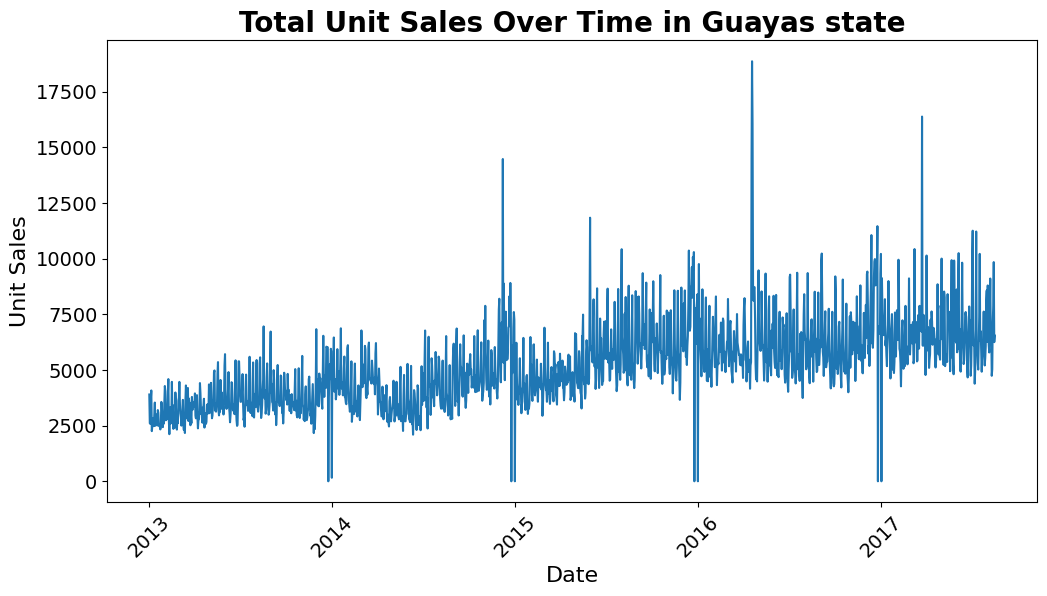

In [8]:
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## Sales Trend by Year and Month

- Shows a much clearer movement of the mean, with colors getting progressively warmer from 2013 to 2017
- October 2017 is likely a truncated month in terms of data collection, leading to the starkly lower sales figures.
- December is always the best-performing month for every year. December sales have progressively gotten better year after year. Might reflect spending closer to the holidays, as well as potential income boost from holiday bonuses.
- January to April seem to be the slowest months in general, with sales ramping up soon afterwards.

In [9]:
# unstack reshapes the results so that:
# - each row is a year
# - each column is a month (1-12)
# - the values are the total sales
sales_by_month = (
    df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()
)

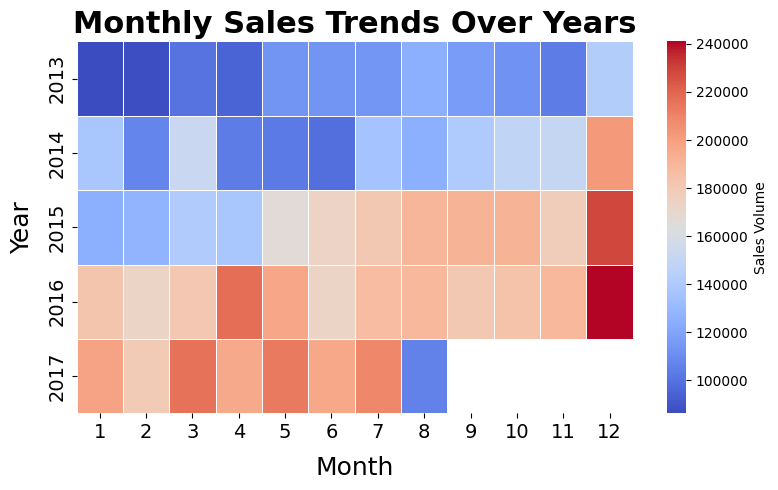

In [10]:
import seaborn as sns

plt.figure(figsize=(8,5))

sns.heatmap(
    sales_by_month,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Sales Volume'}
)

plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Year', fontsize=18, labelpad=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

plt.show()

## Impact of Holidays on Sales
- though a majority of our sales records did not occur during a holiday (18,798,665 rows), they did not account for the most sales. This is likely due to the most of these rows being added by the `fill_calendar` method.
- Work days and additional holidays show the highest sales performance among the holiday types.
- Regular holidays seem to have a negative impact on sales. Could be because there are some holidays when the stores are closed, bringing the average down? People may also choose to spend their holidays doing something other than shopping in a retail store.
- It's curious that transfer holidays show a markedly higher sales performance than regular holidays (rank 3). Do people follow their regular shopping routines when holidays are transferred?

In [11]:
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

print(
    'Holiday file covers:',
    df_holiday_events['date'].dt.date.min(),
    df_holiday_events['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 2017-12-26


In [12]:
df_train_holiday = pd.merge(
    df_train,
    df_holiday_events[['date', 'type']],
    on='date',
    how='left'
)
df_train_holiday.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,is_holiday,family,class,perishable,city,type_x,state,unit_sales_7d_avg,year,month,day,day_of_week,type_y
0,2013-01-17,622071,24,96995,2.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,2.000000,2013,1,17,3,NaN
1,2013-01-18,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,1.000000,2013,1,18,4,NaN
2,2013-01-19,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.666667,2013,1,19,5,NaN
3,2013-01-20,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.500000,2013,1,20,6,NaN
4,2013-01-21,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.400000,2013,1,21,0,NaN


In [13]:
df_train_holiday['type_y'].value_counts()

,count
type_y,
Holiday,2314563
Event,843324
Additional,522319
Transfer,130409
Work Day,47195
Bridge,42342


In [14]:
df_train['class'].value_counts()
# there were 20_987_767 rows added by fill_calendar

,count
class,
1040,1203819
1016,928168
1122,899409
1124,886183
1034,819380
...,...
1018,1337
1156,532
1041,244


In [15]:
df_train_holiday['type_y'] = df_train_holiday['type_y'].fillna('Not Holiday')
df_train_holiday['type_y'].unique()

array(['Not Holiday', 'Holiday', 'Additional', 'Event', 'Transfer',
       'Work Day', 'Bridge'], dtype=object)

In [16]:
df_train_holiday['type_y'].value_counts()

,count
type_y,
Not Holiday,18798665
Holiday,2314563
Event,843324
Additional,522319
Transfer,130409
Work Day,47195
Bridge,42342


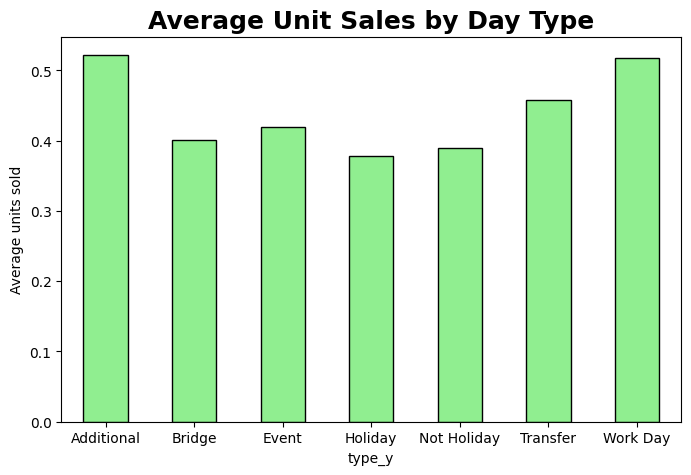

In [17]:
holiday_sales = df_train_holiday.groupby('type_y')['unit_sales'].mean()

holiday_sales.plot(
    kind='bar',
    figsize=(8,5),
    color='lightgreen',
    edgecolor = 'black'
)

plt.title('Average Unit Sales by Day Type', fontsize=18, weight='bold')
plt.ylabel('Average units sold')
plt.xticks(rotation=0)
plt.show()

In [18]:
del(holiday_sales)
del(df_train_holiday)

## Perishable Items Analysis
- it is shocking to see that there were no perishable sales for the Guayas region.
- looking through `df_train`, the only product families available were GROCERY I, CLEANING, and BEVERAGES, which do not belong to the list of perishable product families.
- could this be a sampling and filtering artifact i.e. by chance when picking 2 million rows from the original dataset and then filtering down to Guayas, we somehow excluded all perishable sales? I find it hard to believe.
- if this is true, then Guayas stores are either grossly underserving their customers by not offering any perishable items, or they have really found through optimization that they should not carry perishable items and have focused entirely on long-lasting ones.

In [19]:
df_items.loc[df_items['perishable'] == True]['family'].unique()

array(['BREAD/BAKERY', 'DELI', 'POULTRY', 'EGGS', 'DAIRY', 'MEATS',
       'SEAFOOD', 'PREPARED FOODS', 'PRODUCE'], dtype=object)

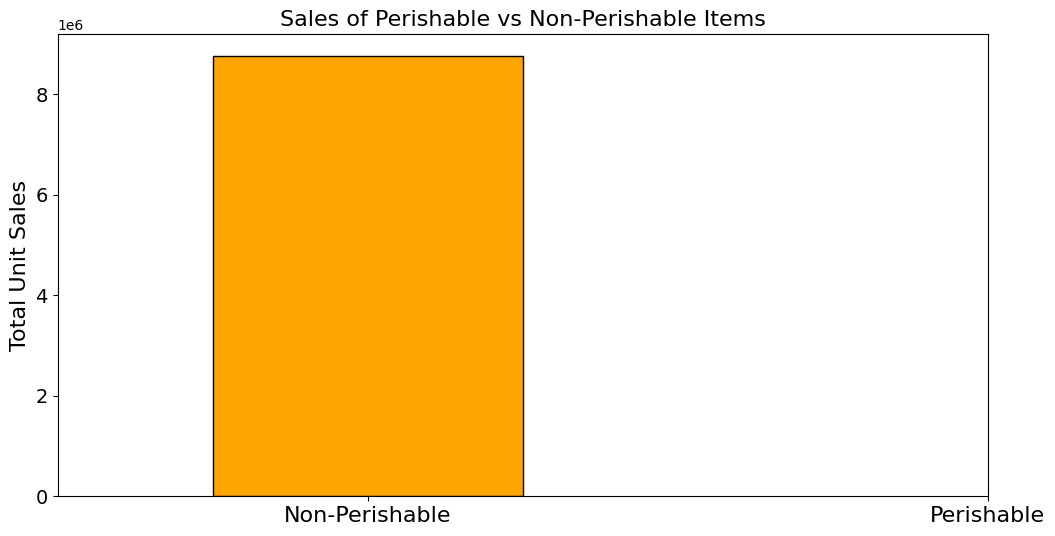

In [20]:
perishable_sales = df_train.groupby('perishable')['unit_sales'].sum()

perishable_sales.plot(
    kind='bar',
    figsize=(12,6),
    color=['orange', 'green'],
    edgecolor='black'
)


plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0
)
plt.yticks(fontsize=14)
plt.show()

In [21]:
df_train['family'].unique()

array(['GROCERY I', 'CLEANING', 'BEVERAGES'], dtype=object)

## Impact of Oil Prices
- Initial reaction: oil prices were high in 2013, corresponding to lower sales. As oil prices plummeted, the sales have increased.
- however, there doessn't really seem to be a close mirroring. Though oil prices crashed to its lowest point in 2016, that period did not mark the highest sales. In fact, the biggest spike coincided with an uptrend in oil prices.
- also, oil prices seem to be on the upward trend again, and yet sales are also rising, making me think oil prices may not have a big effect on sales.

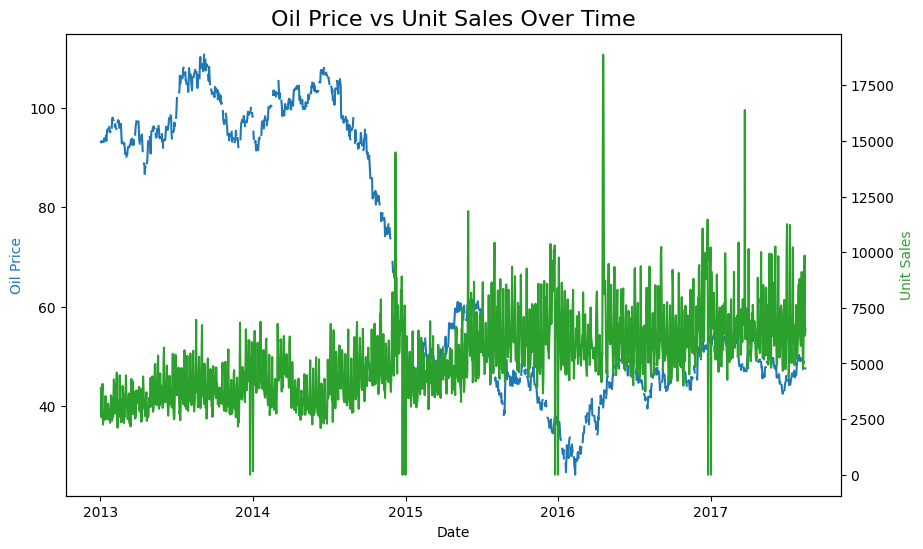

In [22]:
# Make sure the date column is a real datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])

daily_sales = df_train.groupby('date')['unit_sales'].sum()

# Merging df_train with oil data on date
df_train_oil = pd.merge(daily_sales, df_oil, on='date', how='left')

# Plotting oil price vs unit sales
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Price', color='tab:blue')
ax1.plot(df_train_oil['date'], df_train_oil['dcoilwtico'], color='tab:blue', label='Oil Price')
ax2 = ax1.twinx()
ax2.set_ylabel('Unit Sales', color='tab:green')
ax2.plot(df_train_oil['date'], df_train_oil['unit_sales'], color='tab:green', label='Unit Sales')

plt.title('Oil Price vs Unit Sales Over Time', fontsize=16)
plt.show()

## Random Store-Product Sales Trend
- Product 1079331 was only sold from store 51 on 62 separate days from 2013 to early 2017.
- Sales seem to have peaked in the first half of 2014, after which the sales averages seem to have gone back down.

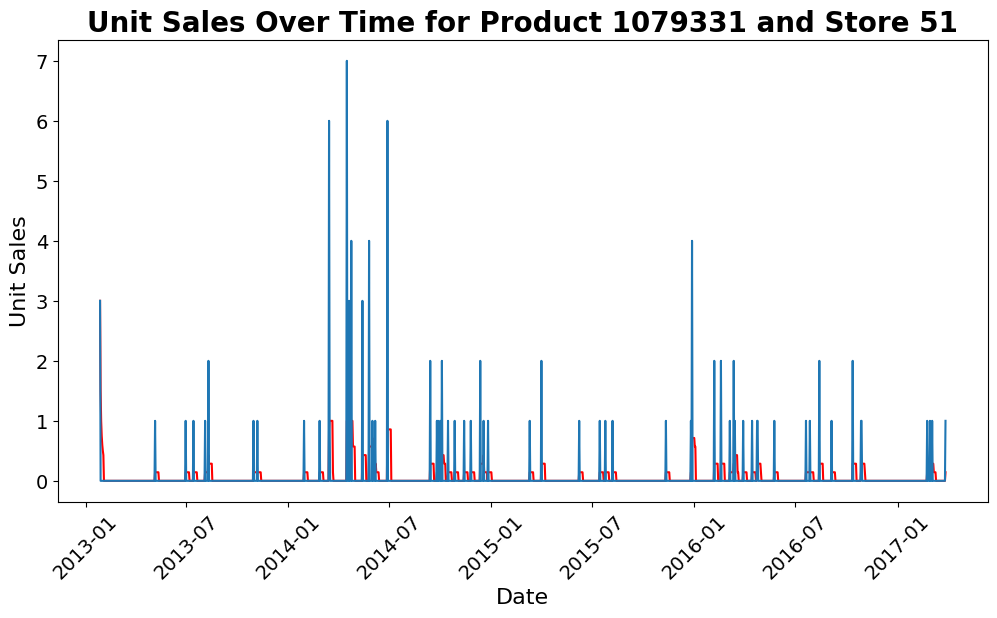

In [23]:
# select a random store and product combination
# limit only to items that had definitive sales
df_sold_items = df_train[df_train['unit_sales']>0]

random_item = df_sold_items.sample(n=1, random_state=42)

store_nbr = random_item.iloc[0]['store_nbr']
item_nbr = random_item.iloc[0]['item_nbr']

df_store_item = (
    df_train[(df_train['store_nbr']==store_nbr) & (df_train['item_nbr'] == item_nbr)]
)

specific_sales_by_date = df_store_item.groupby('date', as_index=False)['unit_sales'].sum()

specific_sales_by_date["sales_7d_avg"] = (
  specific_sales_by_date["unit_sales"]
    .transform(lambda s: s.rolling(window=7, min_periods=1).mean())
)

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(specific_sales_by_date['date'],
         specific_sales_by_date['sales_7d_avg'],
         color='red')
plt.plot(specific_sales_by_date['date'], specific_sales_by_date['unit_sales'])
plt.title(f'Unit Sales Over Time for Product {item_nbr} and Store {store_nbr}',
          fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [24]:
len(df_store_item[df_store_item['unit_sales']>0])

62

## Autocorrelation

- the plot is around 0.7 for the first few days, and remains at 0.5+ at a lag of around 75 days, meaning there's strong autocorrelation.
- The autocorrelation decay is very slow, with sales being affected by figures from a year ago still at around 0.4
- The strongest autocorrelationss seem to be at lag 1 (i.e. day before) and lag 7 (i.e. same day the week before)

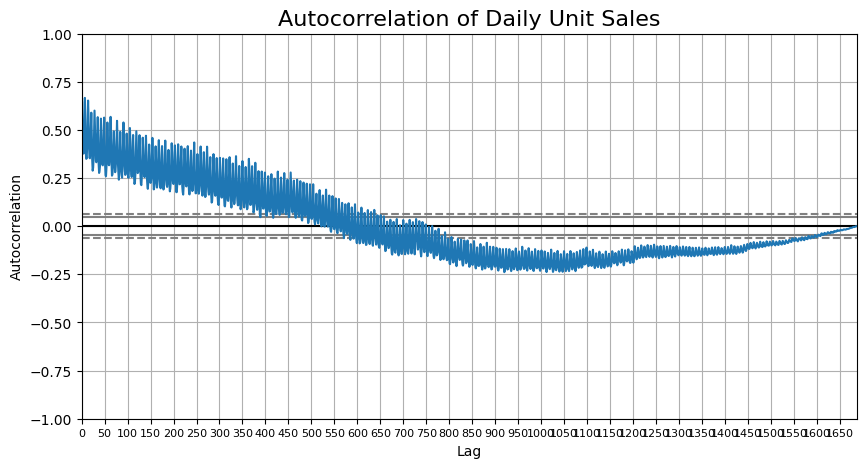

In [25]:
from pandas.plotting import autocorrelation_plot

# Aggregate total sales per day
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plot autocorrelation
plt.figure(figsize=(10, 5))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16)
plt.xticks(np.arange(0, 1700, step=50), fontsize=8)
plt.show()


<Figure size 1600x800 with 0 Axes>

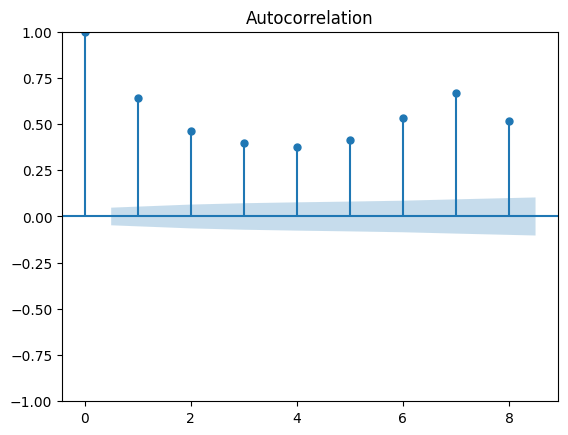

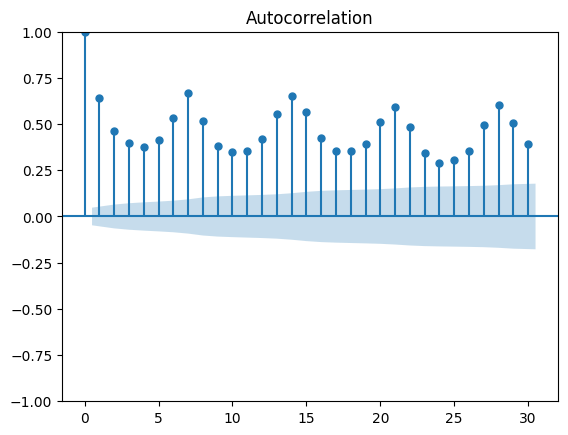

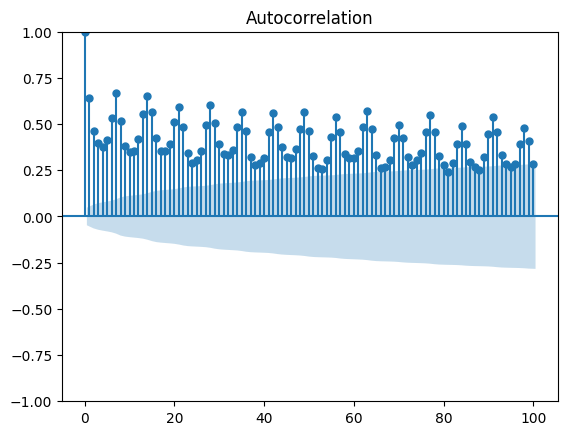

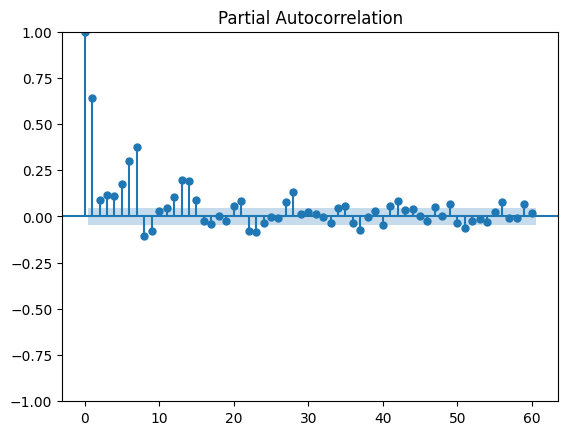

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(16, 8))
plot_acf(sales_by_date, lags=8)
plt.show()
plot_acf(sales_by_date, lags=30)
plt.show()
plot_acf(sales_by_date, lags=100)
plt.show()
plot_pacf(sales_by_date, lags=60)
plt.show()

## Stationarity
- from our Sales Over Time (Aggregated) graph we can see an upward trend and seasonal cycles, firmly suggesting our data is not stationary.
- charting the rolling mean more clearly shows the upward trend.
- variance also fluctuates but seems to hover around the same level and is more stable than the mean.
- dataset has non-stationary mean, but perhaps a stationary variance.
-  After conducting ADF, we get a p-value of 0.054, wwhich means there is not enough evidence to suggest that the data is stationary.

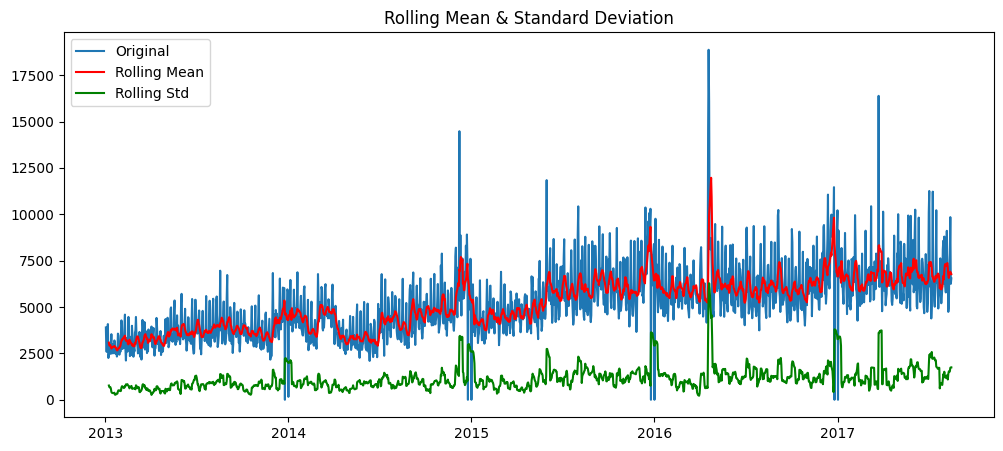

In [27]:
rolling_mean = sales_by_date.rolling(window=7).mean()
rolling_std = sales_by_date.rolling(window=7).std()

plt.figure(figsize=(12,5))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [28]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_by_date)
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")

ADF Statistic: -2.826949744566892
p-value: 0.05452611065435722
The data is not stationary.


### Trend and Seasonality
- the dataset shows a strong trend and moderate seasonality, again supporting how the data is non-stationary.
- visual inspection of the seasonality plot from STL and even moreso from seasonal_decompose show repeating yearly patterns. For example:

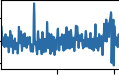


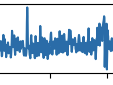

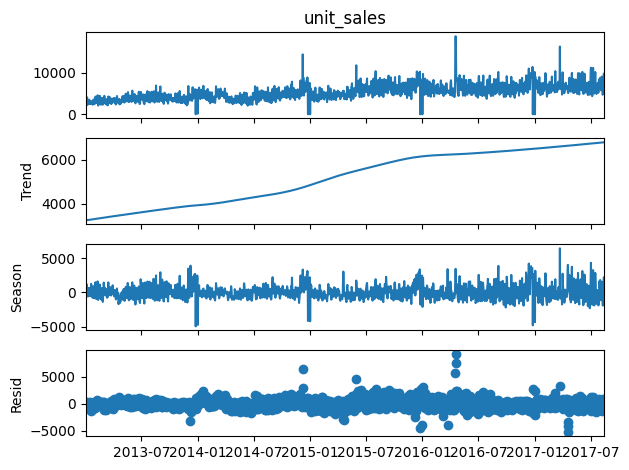

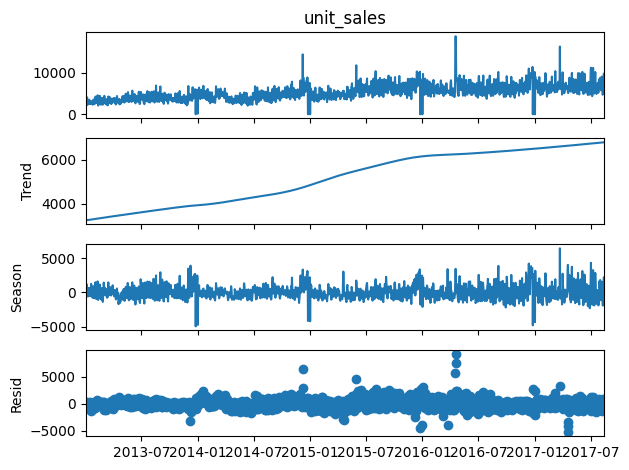

In [29]:
from statsmodels.tsa.seasonal import STL

# STL decomposition
stl = STL(sales_by_date, period=365)
res = stl.fit()

# Plot STL decomposition
res.plot()

In [30]:
# Calculate strength of trend and seasonality
# Based on Hyndman’s definition:
# Strength = 1 - (variance of remainder / variance of (component + remainder))

import numpy as np

trend_strength = 1 - (np.var(res.resid) / np.var(res.trend + res.resid))
seasonal_strength = 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid))

print(f"Strength of Trend: {trend_strength:.2f}")
print(f"Strength of Seasonality: {seasonal_strength:.2f}")

Strength of Trend: 0.67
Strength of Seasonality: 0.64


<Figure size 2400x1600 with 0 Axes>

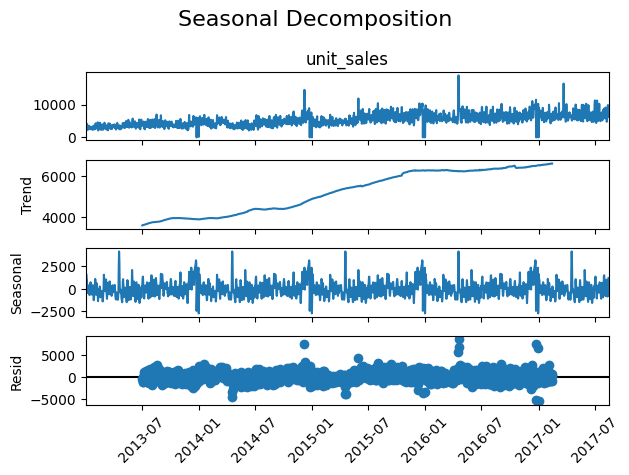

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
decomposition = seasonal_decompose(sales_by_date, period=365)

# Plot seasonal decomposition
plt.figure(figsize=(24, 16))
decomposition.plot()
plt.suptitle("Seasonal Decomposition", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,is_holiday,family,class,perishable,city,type,state,unit_sales_7d_avg,year,month,day,day_of_week
0,2013-01-17,622071,24,96995,2.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,2.000000,2013,1,17,3
1,2013-01-18,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,1.000000,2013,1,18,4
2,2013-01-19,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.666667,2013,1,19,5
3,2013-01-20,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.500000,2013,1,20,6
4,2013-01-21,0,24,96995,0.0,False,False,False,GROCERY I,1093,False,Guayaquil,D,Guayas,0.400000,2013,1,21,0


# Initial Attempt: Linear Regression

In [33]:
sales_by_date_train = pd.DataFrame(sales_by_date.copy())
sales_by_date_train['unit_sales'] = pd.to_numeric(
    sales_by_date_train['unit_sales'], errors='coerce'
)

# add rolling mean 7 (weekly sales), shift by 7 to prevent leakage
sales_by_date_train['rolling_mean_7'] = sales_by_date_train['unit_sales'].rolling(window=7).mean().shift(7)

# add lag 1, 7, 14, 28
for i in [1, 7, 14, 28]:
    sales_by_date_train[f'lag_{i}'] = sales_by_date_train['unit_sales'].shift(i)

# extract day of week
sales_by_date_train.index = pd.to_datetime(sales_by_date_train.index, errors="coerce")
sales_by_date_train['day_of_week'] = sales_by_date_train.index.dayofweek

In [34]:
sales_by_date_train.head()

,unit_sales,rolling_mean_7,lag_1,lag_7,lag_14,lag_28,day_of_week
date,,,,,,,
2013-01-02,3900.0,NaN,NaN,NaN,NaN,NaN,2
2013-01-03,2605.0,NaN,3900.0,NaN,NaN,NaN,3
2013-01-04,2581.0,NaN,2605.0,NaN,NaN,NaN,4
2013-01-05,3674.0,NaN,2581.0,NaN,NaN,NaN,5
2013-01-06,4081.0,NaN,3674.0,NaN,NaN,NaN,6


In [35]:
features = sales_by_date_train.columns.drop(['unit_sales'])
target = 'unit_sales'

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

In [37]:
data = sales_by_date_train.copy().dropna()

#predict sales in the next 30 days

train = data[:-30]
test = data [-30:]

In [38]:
print(train.shape)
print(test.shape)

(1629, 7)
(30, 7)


In [39]:
model = LinearRegression()
model.fit(train[features], train[target])

test_preds = model.predict(test[features])
train_preds = model.predict(train[features])

print(f'Train R2: {r2_score(train[target], train_preds)}')
print(f'Test R2: {r2_score(test[target], test_preds)}')

print(f'Train RMSE: {root_mean_squared_error(train[target], train_preds)}')
print(f'Test RMSE: {root_mean_squared_error(test[target], test_preds)}')

Train R2: 0.6234537105814739
Test R2: 0.4079466945086776
Train RMSE: 1124.4329297773177
Test RMSE: 975.9312882307173


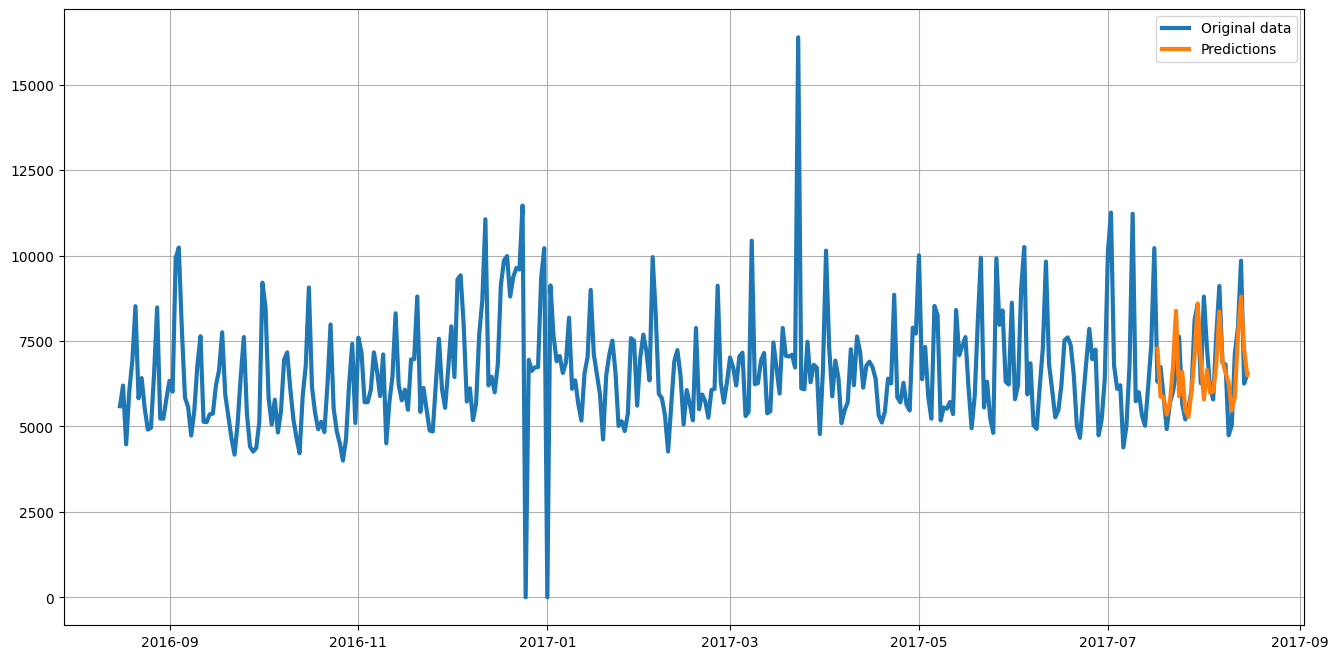

In [40]:
plt.figure(figsize = (16,8))
plt.plot(data[-365:]['unit_sales'], lw = 3, label='Original data')
plt.plot(pd.Series(index = test.index, data = test_preds),
         lw = 3,
         label = 'Predictions')
plt.legend()
plt.grid()
plt.show()

## Cross Validation

0 1539
1 1569
2 1599
3 1629


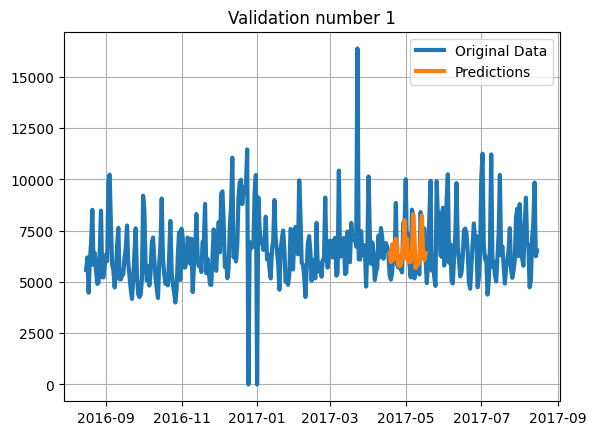

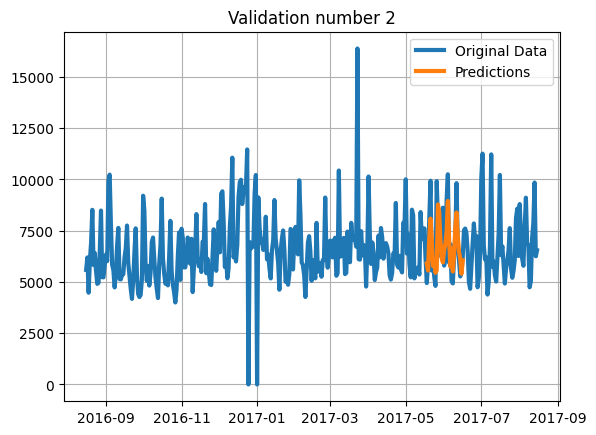

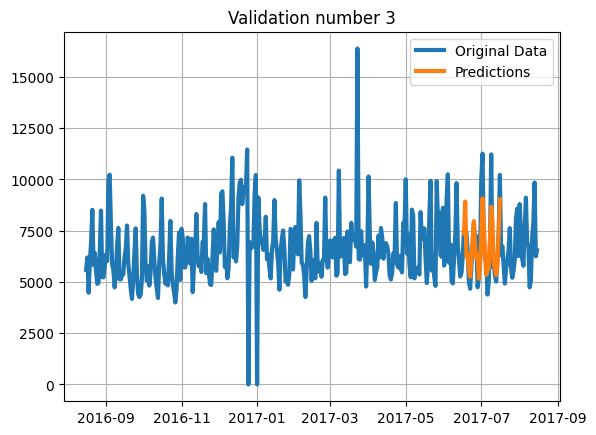

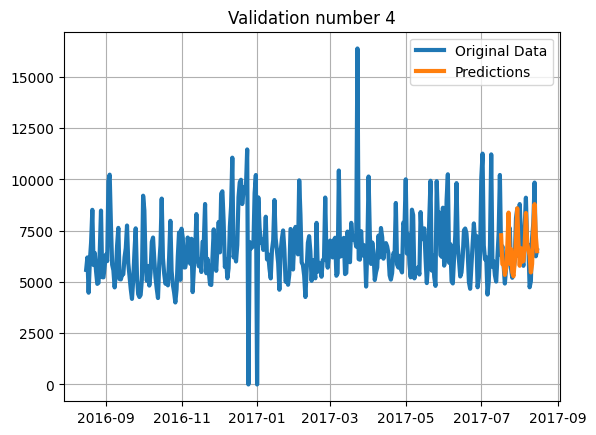

In [41]:
# doing cross validation using TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit


tscv = TimeSeriesSplit(test_size = 30, n_splits = 4)
r2 = list()
rmse = list()

for i, (train_index, test_index) in enumerate(tscv.split(data)):
  train, test = data.iloc[train_index], data.iloc[test_index]
  model = LinearRegression()
  model.fit(train[features], train[target])
  print (i, train.shape[0])

  preds = model.predict(test[features])
  r2.append(r2_score(test[target],preds))
  rmse.append(root_mean_squared_error(test[target], preds))

  plt.figure()
  plt.plot(sales_by_date_train[-365:]['unit_sales'], lw = 3, label = 'Original Data')
  plt.plot(pd.Series(index = test.index, data = preds),
           label = "Predictions", lw = 3)
  plt.grid()
  plt.legend()
  plt.title(f'Validation number {i+1}')

# each cross validation uses the entire data from the beginning

In [42]:
print ('Average R2:', np.mean(r2))
print ('Average RMSE:', np.mean(rmse))

Average R2: 0.3799193950723788
Average RMSE: 1152.5028103721804
